<a href="https://colab.research.google.com/github/ArghaSarker/mitosam-vit/blob/main/train_SAM_FINE_TUNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Install the required libraries
# #SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# #Transformers
# !pip install -q "transformers==4.45.2"
# #Datasets to prepare data and monai if you want to use special loss functions
# !pip install datasets
# !pip install -q monai
# #Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
# !pip install patchify
# !pip install patchify albumentations[imgaug] scikit-image
# # if you will write COCO later:
# !pip install pycocotools
# !pip install --upgrade peft

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_iavmk03
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_iavmk03
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=c11868897fdb737e795d276ccf5560e27400d3ce3116538151160288166de199
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9xk2qir/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 50.0/50.0 MB 71.4 MB/s eta 0:00:01^C


In [1]:
import transformers
print(transformers.__version__)
import sys
print(sys.version)

from peft import TaskType
print(TaskType.__members__)




4.45.2
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
{'SEQ_CLS': <TaskType.SEQ_CLS: 'SEQ_CLS'>, 'SEQ_2_SEQ_LM': <TaskType.SEQ_2_SEQ_LM: 'SEQ_2_SEQ_LM'>, 'CAUSAL_LM': <TaskType.CAUSAL_LM: 'CAUSAL_LM'>, 'TOKEN_CLS': <TaskType.TOKEN_CLS: 'TOKEN_CLS'>, 'QUESTION_ANS': <TaskType.QUESTION_ANS: 'QUESTION_ANS'>, 'FEATURE_EXTRACTION': <TaskType.FEATURE_EXTRACTION: 'FEATURE_EXTRACTION'>}


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from peft import LoraConfig, get_peft_model, TaskType

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import os

base_dir = "/content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/"

# Define paths for both NPZ files
train_output_filename = os.path.join(base_dir, 'train_data_processed.npz')
val_output_filename   = os.path.join(base_dir, 'val_data_processed.npz')

# Load training data
try:
    with np.load(train_output_filename) as data:
        train_img = data['images']
        train_mask = data['masks']
    print(f"--- Loaded Training Data from {os.path.basename(train_output_filename)} ---")
    print(f"  'train_img' shape: {train_img.shape}, dtype: {train_img.dtype}")
    print(f"  'train_mask' shape: {train_mask.shape}, dtype: {train_mask.dtype}")
except FileNotFoundError:
    print(f"Error: The file {train_output_filename} was not found. Please ensure it exists.")
except Exception as e:
    print(f"An error occurred while loading the training NPZ file: {e}")

print("\n") # Add a newline for better readability

# Load validation data
try:
    with np.load(val_output_filename) as data:
        val_img = data['images']
        val_mask = data['masks']
    print(f"--- Loaded Validation Data from {os.path.basename(val_output_filename)} ---")
    print(f"  'val_img' shape: {val_img.shape}, dtype: {val_img.dtype}")
    print(f"  'val_mask' shape: {val_mask.shape}, dtype: {val_mask.dtype}")
except FileNotFoundError:
    print(f"Error: The file {val_output_filename} was not found. Please ensure it exists.")
except Exception as e:
    print(f"An error occurred while loading the validation NPZ file: {e}")


--- Loaded Training Data from train_data_processed.npz ---
  'train_img' shape: (8508, 256, 256), dtype: float32
  'train_mask' shape: (8508, 256, 256), dtype: uint8


--- Loaded Validation Data from val_data_processed.npz ---
  'val_img' shape: (495, 256, 256), dtype: float32
  'val_mask' shape: (495, 256, 256), dtype: uint8


## jsut for debugging, keeping teh data low

In [ ]:
train_img = train_img [:20]
train_mask = train_mask[:20]

val_img = val_img [:5]
val_mask = val_mask[:5]

print(f"  'train_img' shape: {train_img.shape}, dtype: {train_img.dtype}")
print(f"  'train_mask' shape: {train_mask.shape}, dtype: {train_mask.dtype}")

print(f"  'val_img' shape: {val_img.shape}, dtype: {val_img.dtype}")
print(f"  'val_mask' shape: {val_mask.shape}, dtype: {val_mask.dtype}")

  'train_img' shape: (200, 256, 256), dtype: float32
  'train_mask' shape: (200, 256, 256), dtype: uint8
  'val_img' shape: (35, 256, 256), dtype: float32
  'val_mask' shape: (35, 256, 256), dtype: uint8


In [ ]:
import ipywidgets as widgets
from IPython.display import display

print("ipywidgets and IPython.display imported successfully.")

ipywidgets and IPython.display imported successfully.


## Visualize train dataset

In [ ]:
def plot_train_data(start_index):
    """
    Plots 4 training images and their corresponding masks in a 2x4 grid,
    looping through the dataset if indices exceed bounds.
    """
    plt.figure(figsize=(8, 5))

    for i in range(4):
        # Calculate the current_index, looping back to the start if out of bounds
        current_index = (start_index + i) % len(train_img)

        # Plot training image
        plt.subplot(2, 4, i + 1) # First row for images
        plt.imshow(train_img[current_index], cmap='gray')
        plt.title(f"Image {current_index}")
        plt.axis('off')

        # Plot training mask
        plt.subplot(2, 4, i + 1 + 4) # Second row for masks
        plt.imshow(train_mask[current_index], cmap='gray')
        plt.title(f"Mask {current_index}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("plot_train_data function redefined to display 4 looping images.")

plot_train_data function redefined to display 4 looping images.


In [ ]:
image_slider = widgets.IntSlider(
    min=0,
    max=len(train_img) - 1,
    step=1,
    description='Start Index (Train):'
)

print("Interactive slider for training data updated. Displaying interactive plot.")

# Use interact to connect the slider to the plotting function
widgets.interactive(plot_train_data, start_index=image_slider)

Interactive slider for training data updated. Displaying interactive plot.


interactive(children=(IntSlider(value=0, description='Start Index (Train):', max=199), Output()), _dom_classes…

## Visualize validation dataset

In [ ]:
def plot_val_data(start_index):
    """
    Plots 4 validation images and their corresponding masks in a 2x4 grid,
    looping through the dataset if indices exceed bounds.
    """
    plt.figure(figsize=(8, 5))

    for i in range(4):
        # Calculate the current_index, looping back to the start if out of bounds
        current_index = (start_index + i) % len(val_img)

        # Plot validation image
        plt.subplot(2, 4, i + 1) # First row for images
        plt.imshow(val_img[current_index], cmap='gray')
        plt.title(f"Image {current_index}")
        plt.axis('off')

        # Plot validation mask
        plt.subplot(2, 4, i + 1 + 4) # Second row for masks
        plt.imshow(val_mask[current_index], cmap='gray')
        plt.title(f"Mask {current_index}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("plot_val_data function redefined to display 4 looping images.")

plot_val_data function redefined to display 4 looping images.


In [ ]:
val_image_slider = widgets.IntSlider(
    min=0,
    max=len(val_img) - 1,
    step=1,
    description='Start Index (Validation):'
)

print("Interactive slider for validation data updated. Displaying interactive plot.")

# Use interact to connect the slider to the plotting function
widgets.interactive(plot_val_data, start_index=val_image_slider)

Interactive slider for validation data updated. Displaying interactive plot.


interactive(children=(IntSlider(value=0, description='Start Index (Validation):', max=34), Output()), _dom_cla…

# now lets start creating the SAM datloader

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
train_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_img],
    "label": [Image.fromarray(mask) for mask in train_mask],
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(train_dataset_dict)

# for val images

# Convert the NumPy arrays to Pillow images and store them in a dictionary
val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_img],
    "label": [Image.fromarray(mask) for mask in val_mask],
}

# Create the dataset using the datasets.Dataset class
val_dataset = Dataset.from_dict(val_dataset_dict)

In [ ]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 35
})

In [ ]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 200
})

## cheking the training dataset

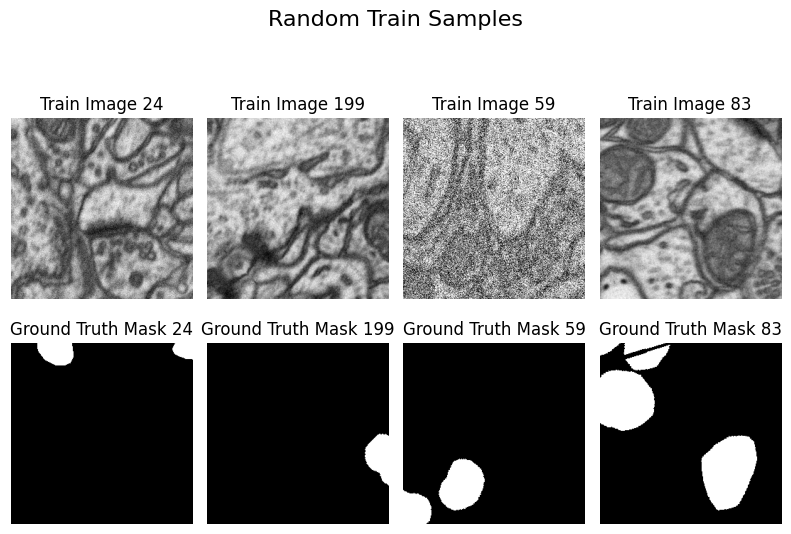

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

n_show = 4

# Pick 4 random Python int indices
idxs = random.sample(range(len(train_dataset)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(2 * n_show, 6))

for col, idx in enumerate(idxs):
    sample = train_dataset[idx]          # idx is a plain int
    img = np.array(sample['image'])
    msk = np.array(sample['label'])

    # Top row: images
    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].set_title(f'Train Image {idx}')
    axes[0, col].axis('off')

    # Bottom row: masks
    axes[1, col].imshow(msk, cmap='gray')
    axes[1, col].set_title(f'Ground Truth Mask {idx}')
    axes[1, col].axis('off')

fig.suptitle('Random Train Samples', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## checking the validation dataset

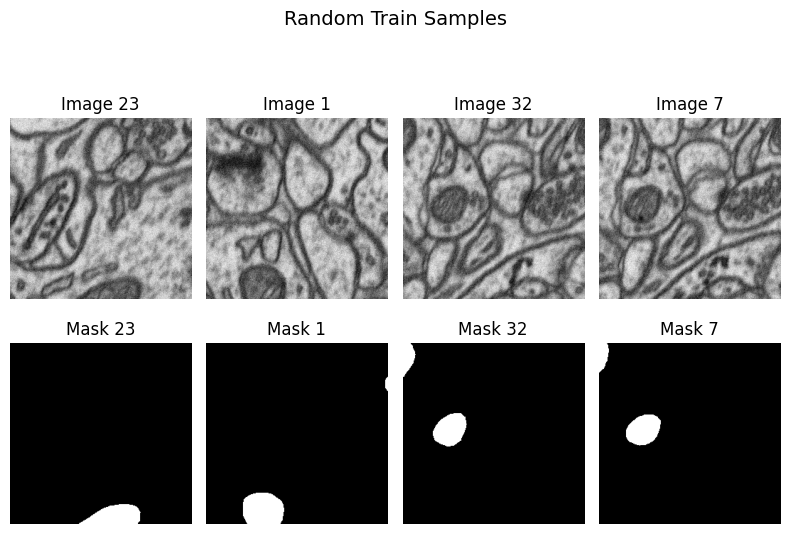

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

n_show = 4

# pick 4 random indices from the dataset
idxs = random.sample(range(len(val_dataset)), n_show)

fig, axes = plt.subplots(2, n_show, figsize=(2 * n_show, 6))

for col, img_num in enumerate(idxs):
    example_image = val_dataset[img_num]["image"]
    example_mask  = val_dataset[img_num]["label"]

    # Top row: images
    axes[0, col].imshow(np.array(example_image), cmap='gray')
    axes[0, col].set_title(f"Image {img_num}")
    axes[0, col].axis('off')

    # Bottom row: masks
    axes[1, col].imshow(np.array(example_mask), cmap='gray')
    axes[1, col].set_title(f"Mask {img_num}")
    axes[1, col].axis('off')

plt.suptitle("Random Train Samples", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## creating promt:
the promts are going to be bounding boxes. so now lets extarct bounding boxes from the segmentions and add them into image

In [ ]:
import numpy as np
from scipy import ndimage

def get_bounding_boxes(mask, perturb=True, max_perturb=20):
    """
    Compute bounding boxes for each connected object in a binary mask.

    Args:
        mask (ndarray): Binary mask (H, W), with nonzero pixels for objects.
        perturb (bool): If True, adds small random perturbation to each bbox.
        max_perturb (int): Maximum random expansion (in pixels).

    Returns:
        boxes (list of [x_min, y_min, x_max, y_max])
    """
    boxes = []
    labeled_mask, num_features = ndimage.label(mask > 0)

    H, W = mask.shape
    for i in range(1, num_features + 1):
        y_indices, x_indices = np.where(labeled_mask == i)
        if len(x_indices) == 0 or len(y_indices) == 0:
            continue

        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        if perturb:
            x_min = max(0, x_min - np.random.randint(0, max_perturb))
            x_max = min(W, x_max + np.random.randint(0, max_perturb))
            y_min = max(0, y_min - np.random.randint(0, max_perturb))
            y_max = min(H, y_max + np.random.randint(0, max_perturb))

        boxes.append([x_min, y_min, x_max, y_max])

    return boxes


## break down the mask as

[(image, mask, [boxA, boxB, boxC] )] --> [
    (image, mask, boxA),
    (image, mask, boxB),
    (image, mask, boxC),
    (image, mask, box_union)
]

In [ ]:
def expand_dataset_with_bboxes(images, masks, include_merged=True, perturb=True, max_perturb=20, return_individual_boxes=True):
    """
    Expands the dataset by duplicating each image for every bounding box in its mask.
    Optionally adds one merged bounding box that covers all objects.

    Args:
        images (list of np.ndarray or PIL.Image): Input images.
        masks (list of np.ndarray or PIL.Image): Corresponding masks.
        include_merged (bool): If `return_individual_boxes` is True, whether to add a combined bbox covering all objects.
                                 Irrelevant if `return_individual_boxes` is False.
        perturb (bool): Whether to randomly expand boxes slightly (for data augmentation).
        max_perturb (int): Maximum random expansion for perturbation.
        return_individual_boxes (bool): If True, returns individual bounding boxes and optionally a merged box.
                                        If False, returns only one bounding box per image covering all objects in the mask.

    Returns:
        list of dict: [{"image": img, "mask": mask, "bbox": box}, ...]
    """
    expanded_data = []

    for img, mask in zip(images, masks):
        mask_array = np.array(mask)

        if return_individual_boxes:
            bboxes = get_bounding_boxes(mask_array, perturb=perturb, max_perturb=max_perturb)

            # Add one record per bounding box
            for bbox in bboxes:
                expanded_data.append({"image": img, "mask": mask, "bbox": bbox})

            # Optionally add a merged bounding box covering all
            if include_merged and len(bboxes) > 1:
                all_xmin = min(b[0] for b in bboxes)
                all_ymin = min(b[1] for b in bboxes)
                all_xmax = max(b[2] for b in bboxes)
                all_ymax = max(b[3] for b in bboxes)
                merged_box = [all_xmin, all_ymin, all_xmax, all_ymax]
                expanded_data.append({"image": img, "mask": mask, "bbox": merged_box})
        else: # return_individual_boxes is False, only one big bounding box per image
            y_indices, x_indices = np.where(mask_array > 0)
            if len(x_indices) > 0 and len(y_indices) > 0:
                x_min, x_max = np.min(x_indices), np.max(x_indices)
                y_min, y_max = np.min(y_indices), np.max(y_indices)

                H, W = mask_array.shape
                if perturb:
                    x_min = max(0, x_min - np.random.randint(0, max_perturb))
                    x_max = min(W, x_max + np.random.randint(0, max_perturb))
                    y_min = max(0, y_min - np.random.randint(0, max_perturb))
                    y_max = min(H, y_max + np.random.randint(0, max_perturb))

                single_box = [x_min, y_min, x_max, y_max]
                expanded_data.append({"image": img, "mask": mask, "bbox": single_box})

    print(f" Expanded dataset: {len(images)} → {len(expanded_data)} samples (after bbox duplication)")
    return expanded_data

# expend teh dataset now

In [ ]:
expanded_train = expand_dataset_with_bboxes(
    train_dataset_dict["image"], train_dataset_dict["label"],
    include_merged=True,
    return_individual_boxes=False
)

expanded_val = expand_dataset_with_bboxes(
    val_dataset_dict["image"], val_dataset_dict["label"],
    include_merged=True,
    return_individual_boxes=False
)

 Expanded dataset: 200 → 198 samples (after bbox duplication)
 Expanded dataset: 35 → 35 samples (after bbox duplication)


In [ ]:
expanded_train[4]

{'image': <PIL.Image.Image image mode=F size=256x256>,
 'mask': <PIL.Image.Image image mode=L size=256x256>,
 'bbox': [22, 43, 256, 233]}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

def visualize_expanded_dataset(expanded_data, n_cols=5, cell_size=2.2):
    """
    Interactive visualization of expanded dataset.
    Shows top row: images; bottom row: masks with bounding boxes.
    Smaller layout for compact display.
    """
    total = len(expanded_data)

    slider = widgets.IntSlider(
        min=0,
        max=max(0, total - 1),
        step=n_cols,
        value=0,
        description="Start index:",
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    output = widgets.Output()

    def show_samples(start_idx):
        with output:
            clear_output(wait=True)
            fig, axes = plt.subplots(2, n_cols, figsize=(cell_size * n_cols, cell_size * 2))
            fig.suptitle(f"Samples {start_idx} → {start_idx + n_cols - 1}", fontsize=10)

            for i in range(n_cols):
                idx = (start_idx + i) % total
                entry = expanded_data[idx]
                img = np.array(entry["image"])
                mask = np.array(entry["mask"])
                bbox = entry["bbox"]

                # --- Top row: image ---
                axes[0, i].imshow(img, cmap="gray")
                axes[0, i].set_title(f"Image #{idx}", fontsize=8)
                axes[0, i].axis("off")

                # --- Bottom row: mask + box ---
                axes[1, i].imshow(mask, cmap="gray")
                if bbox is not None:
                    x_min, y_min, x_max, y_max = bbox
                    rect = patches.Rectangle(
                        (x_min, y_min),
                        x_max - x_min,
                        y_max - y_min,
                        linewidth=1.5,
                        edgecolor='red',
                        facecolor='none'
                    )
                    axes[1, i].add_patch(rect)
                axes[1, i].set_title(f"{bbox}", fontsize=7)
                axes[1, i].axis("off")

            plt.tight_layout(pad=1.0)
            plt.show()

    slider.observe(lambda change: show_samples(change["new"]), names="value")
    display(slider, output)
    show_samples(slider.value)


## visualize the expended training data

In [ ]:
visualize_expanded_dataset(expanded_train, n_cols=8, cell_size=2.2)


IntSlider(value=0, continuous_update=False, description='Start index:', max=197, step=8, style=SliderStyle(des…

Output()

## visualize the extended validation data

In [ ]:
visualize_expanded_dataset(expanded_val, n_cols=8, cell_size=2.2)

IntSlider(value=0, continuous_update=False, description='Start index:', max=34, step=8, style=SliderStyle(desc…

Output()

## lets start with defining the model

In [ ]:
# put these imports in the SAME cell as the class, or above it
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image # Ensure Image is imported

class SAMDataset(Dataset):
    def __init__(self, expanded_data, processor):
        self.samples = expanded_data
        self.processor = processor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        entry = self.samples[idx]
        image = entry["image"]            # PIL.Image
        mask  = np.array(entry["mask"])   # H×W
        box   = entry["bbox"]             # [x_min, y_min, x_max, y_max] in ORIGINAL coords

        # Convert single-channel image to RGB if it's not already
        if image.mode != "RGB":
            image = image.convert("RGB")

        enc = self.processor(image, input_boxes=[[box]], return_tensors="pt")
        enc = {k: v.squeeze(0) for k, v in enc.items()}

        enc["ground_truth_mask"] = torch.from_numpy(mask).float()  # H×W
        return enc

In [ ]:
from transformers import SamProcessor
from torch.utils.data import DataLoader

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_dataset = SAMDataset(expanded_train, processor)
val_dataset   = SAMDataset(expanded_val, processor)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False)
val_dataloader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, drop_last=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
enc0 = train_dataset[0]
print("pixel_values:", tuple(enc0["pixel_values"].shape))           # (3, 1024, 1024) typically
print("input_boxes:", tuple(enc0["input_boxes"].shape))             # (1, 4)
print("original_sizes:", enc0["original_sizes"].tolist())           # [H_orig, W_orig] ~ [256, 256]
print("reshaped_input_sizes:", enc0["reshaped_input_sizes"].tolist())  # [H_resized, W_resized] ~ [1024, 1024]
print("gt mask:", tuple(enc0["ground_truth_mask"].shape))           # (H_orig, W_orig) ~ (256, 256)


pixel_values: (3, 1024, 1024)
input_boxes: (1, 4)
original_sizes: [256, 256]
reshaped_input_sizes: [1024, 1024]
gt mask: (256, 256)


## visually debug sam sample


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from PIL import Image

def visualize_sam_sample(dataset, idx=0):
    """
    Visualize one processed sample from SAMDataset.
    Shows: (1) SAM-processed image, (2) mask, (3) overlay with bounding box.
    """
    # --- Get one sample ---
    sample = dataset[idx]
    pixel_values = sample["pixel_values"]          # Tensor or array
    mask = sample["ground_truth_mask"]             # Tensor or array
    bbox = sample["input_boxes"]                   # Tensor/array/list

    # --- Convert pixel_values to numpy image ---
    if isinstance(pixel_values, torch.Tensor):
        img = pixel_values.clone().detach()
        # (C, H, W) -> (H, W, C)
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = img.permute(1, 2, 0)
        img = img.cpu().numpy()
    else:
        img = np.array(pixel_values)

    # normalize to [0,1]
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # If grayscale (H, W) make it 3-channel for overlay consistency
    if img.ndim == 2:
        img_rgb = np.stack([img] * 3, axis=-1)
    elif img.ndim == 3 and img.shape[2] == 1:
        img_rgb = np.repeat(img, 3, axis=-1)
    else:
        img_rgb = img

    # --- Convert mask to numpy 2D ---
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    else:
        mask = np.array(mask)

    # squeeze possible channel / batch dims (e.g. (1,H,W) or (H,W,1))
    if mask.ndim > 2:
        mask = np.squeeze(mask)

    # Ensure mask is uint8 for PIL
    mask_uint8 = mask.astype(np.uint8)

    # --- Resize mask to match SAM image size ---
    H, W = img_rgb.shape[:2]
    if mask_uint8.shape != (H, W):
        mask_resized = np.array(
            Image.fromarray(mask_uint8).resize((W, H), Image.NEAREST)
        )
    else:
        mask_resized = mask_uint8

    # --- Create overlay: red where mask > 0 ---
    overlay = img_rgb.copy()
    overlay[mask_resized > 0] = [1.0, 0.0, 0.0]

    # --- Convert bbox to numpy (4,) ---
    if isinstance(bbox, torch.Tensor):
        bbox_np = bbox.squeeze(0).detach().cpu().numpy()  # assume (1,4)
    else:
        bbox_np = np.array(bbox).squeeze()

    x_min, y_min, x_max, y_max = bbox_np

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    titles = ["SAM Input Image", "Ground Truth Mask", "Overlay (Mask + Box)"]

    # 1️⃣ SAM input image
    # if original is grayscale, show the first channel
    axes[0].imshow(img if img.ndim == 2 else img_rgb, cmap="gray" if img.ndim == 2 else None)
    axes[0].set_title(titles[0])
    axes[0].axis("off")

    # 2️⃣ Ground truth mask
    axes[1].imshow(mask_resized, cmap="gray")
    axes[1].set_title(titles[1])
    axes[1].axis("off")

    # 3️⃣ Overlay with bounding box
    axes[2].imshow(overlay)
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor="yellow",
        facecolor="none",
    )
    axes[2].add_patch(rect)
    axes[2].set_title(titles[2])
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # Print details for inspection
    print(f"Sample #{idx}")
    print(f"  pixel_values shape: {sample['pixel_values'].shape}")
    print(f"  input_boxes: {bbox_np}")
    print(f"  mask shape: {mask_resized.shape}, unique values: {np.unique(mask_resized)}")


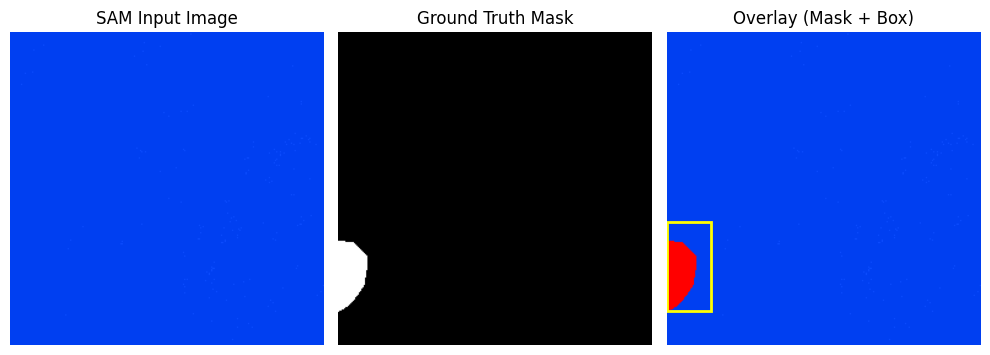

Sample #141
  pixel_values shape: torch.Size([3, 1024, 1024])
  input_boxes: [  0. 620. 144. 912.]
  mask shape: (1024, 1024), unique values: [  0 255]


In [ ]:
import random
idx = random.randint(0, len(train_dataset) - 1)
visualize_sam_sample(train_dataset, idx)


In [ ]:
import torch
from transformers import SamModel
from monai.losses import DiceFocalLoss
from peft import LoraConfig, get_peft_model, TaskType

device = "cuda" if torch.cuda.is_available() else "cpu"

# Base SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# LoRA config applied to attention/projection layers across SAM
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # attention proj layers
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,  # vision / feature task
)

# 🔴 IMPORTANT: wrap the WHOLE model, not model.mask_decoder
model = get_peft_model(model, lora_config)

model.print_trainable_parameters()  # sanity check: % of trainable params

model.to(device)

# Segmentation loss
seg_loss = DiceFocalLoss(
    sigmoid=True,
    lambda_dice=1.0,
    lambda_focal=1.0,
    reduction="mean",
)


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

trainable params: 188,416 || all params: 93,923,888 || trainable%: 0.2006


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Epoch 1/50 | Train Loss: -0.2612 | Val Loss: -0.381005 | LR: 1.00e-03
  ✅ New best val loss: -0.381005. Model saved.


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 2/50 | Train Loss: -0.3551 | Val Loss: -0.386081 | LR: 1.00e-03
  ✅ New best val loss: -0.386081. Model saved.


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 3/50 | Train Loss: -0.3805 | Val Loss: -0.428030 | LR: 1.00e-03
  ✅ New best val loss: -0.428030. Model saved.


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 4/50 | Train Loss: -0.4079 | Val Loss: -0.428688 | LR: 1.00e-03
  No meaningful improvement for 1 epoch(s).


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 5/50 | Train Loss: -0.4243 | Val Loss: -0.386248 | LR: 1.00e-03
  No meaningful improvement for 2 epoch(s).


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 6/50 | Train Loss: -0.4130 | Val Loss: -0.456947 | LR: 1.00e-03
  ✅ New best val loss: -0.456947. Model saved.


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 7/50 | Train Loss: -0.4218 | Val Loss: -0.455156 | LR: 1.00e-03
  No meaningful improvement for 1 epoch(s).


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 8/50 | Train Loss: -0.4348 | Val Loss: -0.444041 | LR: 1.00e-03
  No meaningful improvement for 2 epoch(s).


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 9/50 | Train Loss: -0.4481 | Val Loss: -0.448287 | LR: 1.00e-03
  No meaningful improvement for 3 epoch(s).


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 10/50 | Train Loss: -0.4634 | Val Loss: -0.420478 | LR: 5.00e-04
  No meaningful improvement for 4 epoch(s).


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 11/50 | Train Loss: -0.4777 | Val Loss: -0.406868 | LR: 5.00e-04
  No meaningful improvement for 5 epoch(s).


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 12/50 | Train Loss: -0.4881 | Val Loss: -0.196717 | LR: 5.00e-04
  No meaningful improvement for 6 epoch(s).


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 13/50 | Train Loss: -0.4502 | Val Loss: -0.458073 | LR: 5.00e-04
  ✅ New best val loss: -0.458073. Model saved.


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 14/50 | Train Loss: -0.4710 | Val Loss: -0.357384 | LR: 5.00e-04
  No meaningful improvement for 1 epoch(s).


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 15/50 | Train Loss: -0.4917 | Val Loss: -0.382193 | LR: 5.00e-04
  No meaningful improvement for 2 epoch(s).


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 16/50 | Train Loss: -0.4987 | Val Loss: -0.317250 | LR: 5.00e-04
  No meaningful improvement for 3 epoch(s).


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 17/50 | Train Loss: -0.5102 | Val Loss: -0.019393 | LR: 2.50e-04
  No meaningful improvement for 4 epoch(s).


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 18/50 | Train Loss: -0.5173 | Val Loss: 0.162527 | LR: 2.50e-04
  No meaningful improvement for 5 epoch(s).


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 19/50 | Train Loss: -0.5240 | Val Loss: 0.120231 | LR: 2.50e-04
  No meaningful improvement for 6 epoch(s).


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 20/50 | Train Loss: -0.5225 | Val Loss: 0.172638 | LR: 2.50e-04
  No meaningful improvement for 7 epoch(s).
⏹ Early stopping triggered.


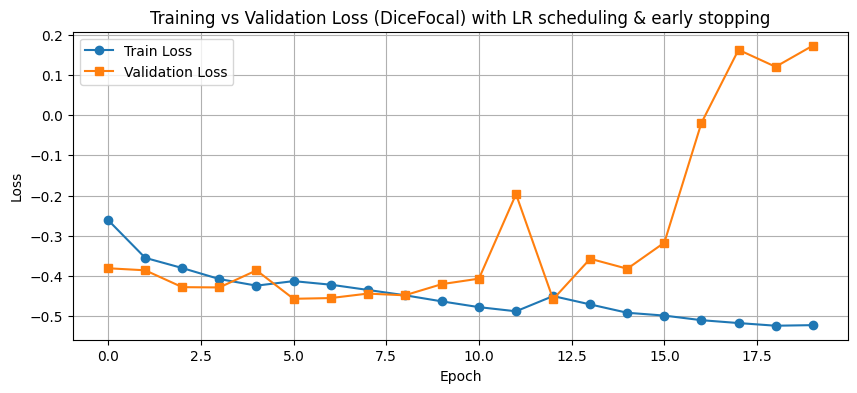

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
import matplotlib.pyplot as plt

# ==========================
# OPTIMIZER, SCHEDULER, EARLY STOP
# ==========================

# Train only parameters that actually require gradients (LoRA adapters, etc.)
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-3,   # Higher LR is fine for PEFT/LoRA
)

# Reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,      # LR = LR * 0.5
    patience=3,      # epochs with no improvement before LR drop
    threshold=0.001, # ignore improvements smaller than this
    threshold_mode="abs",
)

early_stopping_patience = 7        # stop if no improvement for 7 epochs
early_stopping_min_delta = 0.001   # need at least this much improvement in val loss

best_val_loss = float("inf")
epochs_without_improvement = 0

best_model_path = (
    "/content/drive/MyDrive/"
    "Electron_Microscope_Practice_Projects/"
    "Mitochondria_segmentation/best_sam_model.pth"
)

# ==========================
# TRAINING LOOP
# ==========================

num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # ---- TRAIN ----
    model.train()
    epoch_train_losses = []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        pixel_values = batch["pixel_values"].to(device)
        input_boxes = batch["input_boxes"].to(device)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)  # (B, H, W)

        optimizer.zero_grad()

        outputs = model(
            pixel_values=pixel_values,
            input_boxes=input_boxes,
            multimask_output=False,
        )

        predicted_masks = outputs.pred_masks.squeeze(1)  # (B, H_pred, W_pred)

        # Resize GT masks to match predicted mask size if needed
        if ground_truth_masks.shape[-2:] != predicted_masks.shape[-2:]:
            ground_truth_masks = torch.nn.functional.interpolate(
                ground_truth_masks.unsqueeze(1),          # (B, 1, H, W)
                size=predicted_masks.shape[-2:],          # (H_pred, W_pred)
                mode="nearest",
            ).squeeze(1)                                  # (B, H_pred, W_pred)

        loss = seg_loss(
            predicted_masks,
            ground_truth_masks.unsqueeze(1),              # (B, 1, H, W)
        )

        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    mean_train_loss = mean(epoch_train_losses)
    train_losses.append(mean_train_loss)

    # ---- VALIDATION ----
    model.eval()
    epoch_val_losses = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            pixel_values = batch["pixel_values"].to(device)
            input_boxes = batch["input_boxes"].to(device)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            outputs = model(
                pixel_values=pixel_values,
                input_boxes=input_boxes,
                multimask_output=False,
            )

            predicted_masks = outputs.pred_masks.squeeze(1)

            # Match spatial dims
            if ground_truth_masks.shape[-2:] != predicted_masks.shape[-2:]:
                ground_truth_masks = torch.nn.functional.interpolate(
                    ground_truth_masks.unsqueeze(1),
                    size=predicted_masks.shape[-2:],
                    mode="nearest",
                ).squeeze(1)

            val_loss = seg_loss(
                predicted_masks,
                ground_truth_masks.unsqueeze(1),
            )
            epoch_val_losses.append(val_loss.item())

    mean_val_loss = mean(epoch_val_losses)
    val_losses.append(mean_val_loss)

    # ---- LR SCHEDULER: step on validation loss ----
    scheduler.step(mean_val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {mean_train_loss:.4f} | "
        f"Val Loss: {mean_val_loss:.6f} | "
        f"LR: {current_lr:.2e}"
    )

    # ---- EARLY STOPPING ----
    if mean_val_loss < best_val_loss - early_stopping_min_delta:
        best_val_loss = mean_val_loss
        epochs_without_improvement = 0

        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ New best val loss: {best_val_loss:.6f}. Model saved.")
    else:
        epochs_without_improvement += 1
        print(f"  No meaningful improvement for {epochs_without_improvement} epoch(s).")

        if epochs_without_improvement >= early_stopping_patience:
            print("⏹ Early stopping triggered.")
            break

# Optionally reload best checkpoint
model.load_state_dict(torch.load(best_model_path))

# ==========================
# PLOT LOSSES
# ==========================
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (DiceFocal) with LR scheduling & early stopping")
plt.legend()
plt.grid(True)
plt.show()


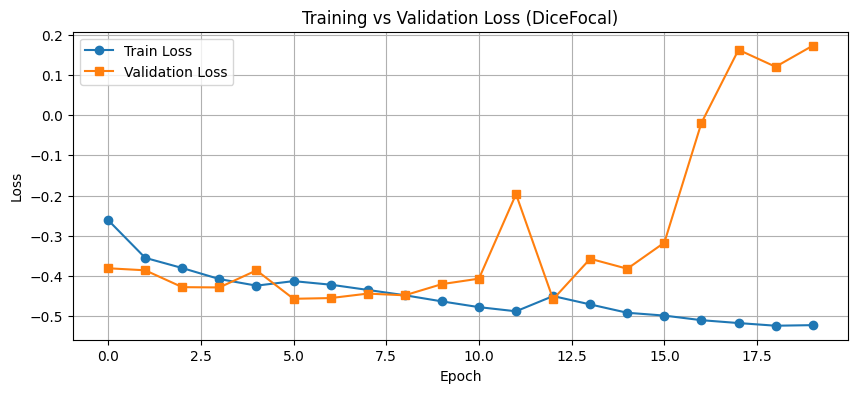

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (DiceFocal)')
plt.legend()
plt.grid(True)
plt.show()

## Inference Step

In [ ]:
from transformers import SamModel, SamProcessor
from peft import LoraConfig, get_peft_model, TaskType
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# ========= CONFIG =========
base_model_name = "facebook/sam-vit-base"
checkpoint_path = best_model_path      # path where you did torch.save(model.state_dict(), ...)
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- 1) Processor (for preprocessing / postprocessing) ---
processor = SamProcessor.from_pretrained(base_model_name)

# --- 2) Rebuild the SAME PEFT model architecture as during training ---
base_model = SamModel.from_pretrained(base_model_name)

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # must match training
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
)

my_mito_model = get_peft_model(base_model, lora_config)

# --- 3) Load trained weights (PEFT + base) ---
state_dict = torch.load(checkpoint_path, map_location=device)
my_mito_model.load_state_dict(state_dict)

my_mito_model.to(device)
my_mito_model.eval()

print("Loaded PEFT-SAM from", checkpoint_path)


Loaded PEFT-SAM from /content/drive/MyDrive/Electron_Microscope_Practice_Projects/Mitochondria_segmentation/best_sam_model.pth


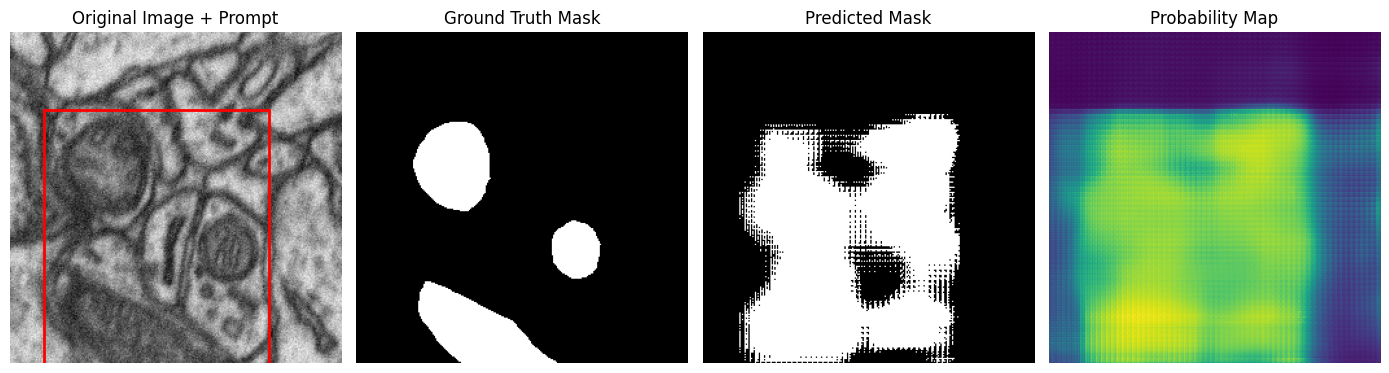

In [ ]:
# ========= INFERENCE ON ONE VALIDATION SAMPLE =========

# 1. Pick a random index from expanded_val
idx = random.randint(0, len(expanded_val) - 1)

# 2. Get original image, GT mask, and the prompt box (in original coords)
sample_expanded = expanded_val[idx]
test_image_display = np.array(sample_expanded["image"])
ground_truth_mask = np.array(sample_expanded["mask"])
prompt_box = sample_expanded["bbox"]  # [x_min, y_min, x_max, y_max]

# 3. Get the preprocessed tensors for the SAME index from val_dataset
sample_proc = val_dataset[idx]
inputs_to_model = {
    "pixel_values": sample_proc["pixel_values"].unsqueeze(0).to(device),
    "input_boxes": sample_proc["input_boxes"].unsqueeze(0).to(device),
    "original_sizes": sample_proc["original_sizes"].unsqueeze(0).to(device),
    "reshaped_input_sizes": sample_proc["reshaped_input_sizes"].unsqueeze(0).to(device),
}

# 4. Run the model
with torch.no_grad():
    outputs = my_mito_model(**inputs_to_model, multimask_output=False)

# 5. Postprocess masks
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.7).astype(np.uint8)

# 6. Visualize: image + box, GT mask, predicted mask, probability map
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

# (1) Original image + bounding box
axes[0].imshow(test_image_display, cmap="gray")
x_min, y_min, x_max, y_max = prompt_box
rect = patches.Rectangle(
    (x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    linewidth=2,
    edgecolor="red",
    facecolor="none",
)
axes[0].add_patch(rect)
axes[0].set_title("Original Image + Prompt")
axes[0].axis("off")

# (2) Ground truth mask
axes[1].imshow(ground_truth_mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

# (3) Predicted binary mask
axes[2].imshow(medsam_seg, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

# (4) Probability heatmap
axes[3].imshow(medsam_seg_prob, cmap="viridis")
axes[3].set_title("Probability Map")
axes[3].axis("off")

plt.tight_layout()
plt.show()
